In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate 

import sys
sys.path.insert(0, '../../packages/')
from data_handlers.DustPredictionDataset import *
from utils.meteorology_printing import *
from training.train_model import *


In [2]:
debug_tensor_path = "../../data/tensors_debug_1/tensor_train_meteorology.pkl"
t = torch.load(debug_tensor_path)
t.shape

torch.Size([48, 17, 81, 81])

<Figure size 432x288 with 0 Axes>

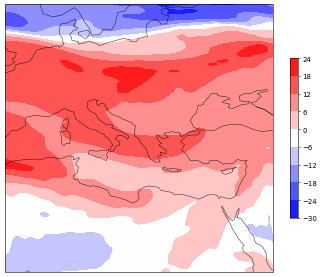

<Figure size 432x288 with 0 Axes>

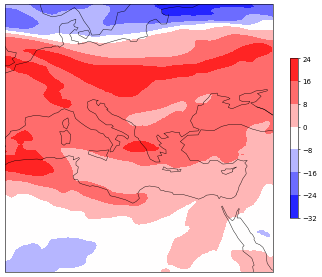

<Figure size 432x288 with 0 Axes>

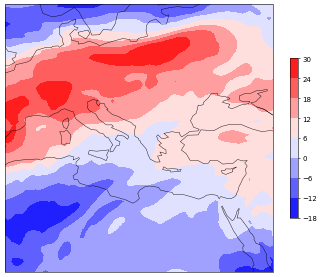

In [3]:
print_parameter(t[3]*0.95+t[20]*0.05,5) 
print_parameter(t[3],5) 
print_parameter(t[20],5) 

In [4]:
noise_set = t[:4,:,:,:]
noise_set.shape

torch.Size([4, 17, 81, 81])

In [5]:
noise_odds = 0.4 # = N/(N+Z)
N = noise_set.shape[0] # N,C,H,W
num_zeros = int(N/noise_odds-N)
N, num_zeros, (N/(N+num_zeros))

(4, 6, 0.4)

In [6]:
N,C,H,W = noise_set.shape
N,C

(4, 17)

In [7]:
noise_set_zeros_expanded = torch.cat((noise_set.new_zeros(num_zeros,noise_set.shape[1],noise_set.shape[2],noise_set.shape[3]),noise_set))
noise_set_zeros_expanded.shape

torch.Size([10, 17, 81, 81])

In [8]:
torch.arange(10.)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [9]:
idxs_to_choose_from = torch.tensor([i for i in range(noise_set_zeros_expanded.shape[0])])*1.
idxs_to_choose_from

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [10]:
choosen_idxs = torch.multinomial(idxs_to_choose_from,num_samples=t.shape[0],replacement=True)

choosen_idxs.shape, choosen_idxs, noise_set_zeros_expanded[choosen_idxs].shape

(torch.Size([48]),
 tensor([9, 5, 6, 3, 6, 9, 9, 9, 6, 7, 8, 7, 5, 9, 5, 3, 5, 9, 6, 6, 6, 8, 8, 7,
         7, 4, 4, 9, 2, 9, 2, 6, 4, 5, 5, 7, 9, 6, 7, 8, 8, 6, 6, 8, 7, 7, 8, 5]),
 torch.Size([48, 17, 81, 81]))

In [11]:
# !pip install git+https://github.com/pvigier/perlin-numpy

Perlin


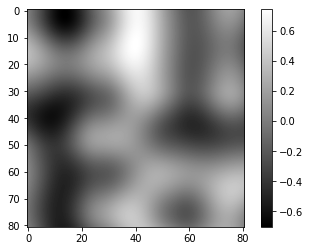

Noise-added


<Figure size 432x288 with 0 Axes>

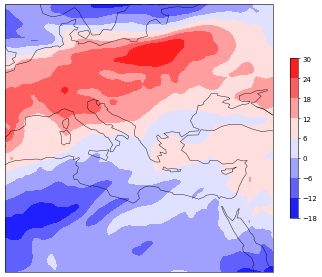

Noise-free


<Figure size 432x288 with 0 Axes>

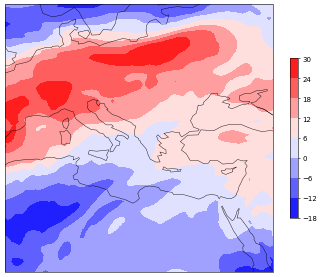

Noise tensor


<Figure size 432x288 with 0 Axes>

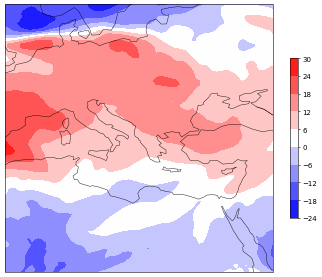

Difference


<Figure size 432x288 with 0 Axes>

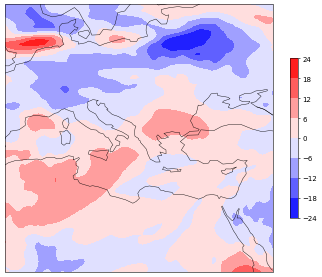

In [12]:
from perlin_numpy import generate_perlin_noise_2d

print("Perlin")
# np.random.seed(0)
noise = generate_perlin_noise_2d((81, 81), (3, 3))
# noise = (noise*(noise>=0))
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()

noise_idx = 11
sample_idx = 20
param_idx = 5
print("Noise-added")
print_parameter(0.95*t[sample_idx]+t[noise_idx]*0.5*noise,param_idx)
print("Noise-free")
print_parameter(t[sample_idx],param_idx)
print("Noise tensor")
print_parameter(t[noise_idx],param_idx)
print("Difference")
print_parameter(t[noise_idx]-t[sample_idx],param_idx)


In [13]:
debug_dir = "../../data/tensors_debug_1/"
debug_meteorology_train_path = debug_dir+"tensor_train_meteorology.pkl"
debug_dust_train_path = debug_dir+"tensor_train_dust.pkl"

metadata_dir = "../../data/metadata_meteo20000101to20210630_dust_0_m24_24_48_72/"
metadata_times_split1_train_path = metadata_dir+"split1_ordered_train_times.pkl"
times_debug = torch.load(metadata_times_split1_train_path)[:48]

debug_tensor_full = torch.load(debug_meteorology_train_path)
debug_dust_full = torch.load(debug_dust_train_path)

debug_tensor_full.shape, debug_dust_full.shape

(torch.Size([48, 17, 81, 81]), torch.Size([48, 10]))

In [14]:
from data_handlers.augmentations import *
from torch.utils.data import Dataset,DataLoader

perlin_augmentation = PerlinAugmentation(debug_tensor_full[10:11,:,:,:], debug_dust_full[10:11,:], debug=True)
print(debug_dust_full[10:11,0])

tensor([36.2833], dtype=torch.float64)


In [15]:
times_debug[0:1]

DatetimeIndex(['2000-06-16 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)

In [16]:
debug_dust_full[0:1,0]

tensor([35.6333], dtype=torch.float64)

In [18]:
dataset_augmented = DustPredictionDataset(debug_tensor_full[0:2,:,:,:],debug_dust_full[0:2,:],times_debug[0:2],
                                                augmentation=perlin_augmentation)

dataset_not_augmented = DustPredictionDataset(debug_tensor_full[0:2,:,:,:],debug_dust_full[0:2,:],times_debug[0:2])

data_loader_augmented = DataLoader(dataset_augmented, batch_size=64, shuffle=True,collate_fn=dataset_augmented.collate_fn)
data_loader_not_augmented = DataLoader(dataset_not_augmented, batch_size=64, shuffle=True,collate_fn=dataset_not_augmented.collate_fn)

sample_data_augmented = next(iter(data_loader_augmented))
print(sample_data_augmented[0][0].shape, sample_data_augmented[0][1].shape, len(sample_data_augmented[1]))

sample_data_not_augmented = next(iter(data_loader_not_augmented))
print(sample_data_not_augmented[0][0].shape, sample_data_not_augmented[0][1].shape, len(sample_data_not_augmented[1]))

t_augmented = sample_data_augmented[0][0]
t_not_augmented = sample_data_not_augmented[0][0]
print(t_augmented.shape,t_not_augmented.shape)

torch.Size([2, 17, 81, 81]) torch.Size([2, 10]) 2
torch.Size([2, 17, 81, 81]) torch.Size([2, 10]) 2
torch.Size([2, 17, 81, 81]) torch.Size([2, 17, 81, 81])


<Figure size 432x288 with 0 Axes>

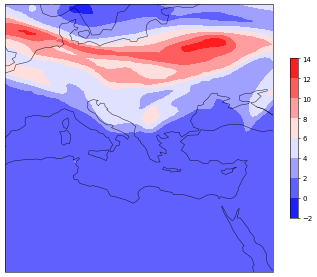

<Figure size 432x288 with 0 Axes>

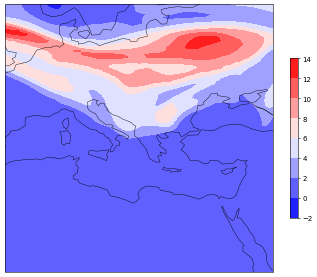

<Figure size 432x288 with 0 Axes>

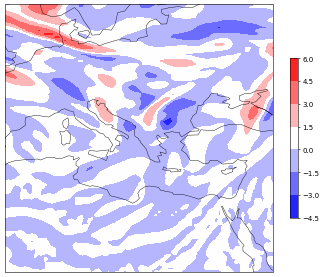

In [30]:
param_idx = 14
print_parameter(t_augmented[0],param_idx)
print_parameter(t_not_augmented[0],param_idx)
print_parameter(t_augmented[0]-t_not_augmented[0],param_idx)


In [19]:
# some experiments with try and exceptions

In [20]:
a = torch.tensor([0])
a

tensor([0])

In [21]:
a.shape

torch.Size([1])

In [22]:
# torch.multinomial(a*1.,num_samples=1,replacement=True)

In [23]:
try:
    print(torch.multinomial(a*1.,num_samples=1,replacement=True))
except Exception as exp:
    print("Nope")
    print(exp)

Nope
invalid multinomial distribution (sum of probabilities <= 0)


In [24]:
a = torch.tensor([[1.],[1.]])
b = torch.tensor([[2.],[2.]])
torch.cat([a,b],1)

tensor([[1., 2.],
        [1., 2.]])

In [25]:
# Loss debug

In [30]:
from training.dust_loss import *

In [31]:
weights_lags = [2,2,2,2,2]

In [32]:
loss_cfg = LossConfig("cpu", lags_indices=None, delta_lags_indices=None, weights_lags=weights_lags, weights_delta_lags=None)

In [33]:
dust_pred = torch.ones([1,10])
dust_target = torch.zeros([1,10])
dust_pred

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [34]:
dust_loss(dust_pred, dust_target, loss_cfg)

tensor(3.0000, dtype=torch.float64)

In [ ]:
# correct
# decaying weights:

In [38]:
np.log(np.exp(1))

1.0

In [42]:
# exp(t=10) = 0.1 = e^(-R*t) => R = -log(0.1)/10
r = -np.log(0.1)/10
np.exp(-r*10)

0.10000000000000002

In [47]:
weights_lags_list = [1., np.exp(-r*1), np.exp(-r*1), np.exp(-r*2), np.exp(-r*3)]
weights_lags_list

[1.0,
 0.7943282347242815,
 0.7943282347242815,
 0.6309573444801932,
 0.5011872336272722]

In [48]:
[weights_lags_list[i]/2 for i in range(len(weights_lags_list))]

[0.5,
 0.39716411736214075,
 0.39716411736214075,
 0.3154786722400966,
 0.2505936168136361]